In [1]:
from models.manage_models import save_model, load_model
from sklearn.ensemble import VotingClassifier
from utils.data_loader import load_split, prepare_features_target
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, fbeta_score, make_scorer
from sklearn.model_selection import learning_curve
import numpy as np

import json
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, fbeta_score, classification_report, confusion_matrix

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

from utils.data_loader import load_split, prepare_features_target


In [2]:
log_regr = load_model('probl1_logistic_regression', 'models/probl1_logistic_regression_20251225_180546.joblib')
svm = load_model('probl1_svm', 'models/probl1_svm_20251225_183323.joblib')

/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle est

In [3]:
train_df = load_split('train', data_dir='dataset/splits')
test_df  = load_split('test', data_dir='dataset/splits')  # VALIDACIÓN

X_train, y_train = prepare_features_target(train_df, target_col="Fault")
X_val, y_val     = prepare_features_target(test_df,  target_col="Fault")

In [5]:
META_PATH = "models/probl1_lr_svm_20251226_115632_metadata.json"

with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

hp = meta.get("hyperparameters", {})

# Params del VotingClassifier (ensemble)
ensemble_params = {}
for k in ["voting", "weights", "flatten_transform", "verbose", "n_jobs"]:
    if k in hp and hp[k] is not None:
        ensemble_params[k] = hp[k]

def keep_only_real_nested_params(d: dict, prefix: str):
    """
    Mantiene SOLO params con '__' después del prefijo.
    Ej:
      OK:  lr__clf__C, lr__scaler__with_mean
      NO:  lr__clf (string), lr__scaler (string), lr__sampler (string)
    """
    out = {}
    for k, v in d.items():
        if not k.startswith(prefix):
            continue
        # queremos cosas tipo lr__X__param
        remainder = k[len(prefix):]  # quita 'lr__' o 'svm__'
        if "__" not in remainder:
            continue
        out[k] = v
    return out

lr_params = keep_only_real_nested_params(hp, "lr__")
svm_params = keep_only_real_nested_params(hp, "svm__")

# FIX: quitar multi_class deprecated en LR (si existe)
lr_params.pop("lr__clf__multi_class", None)

ensemble_params, list(lr_params.keys())[:8], list(svm_params.keys())[:8]


({'voting': 'soft',
  'weights': [1, 2],
  'flatten_transform': True,
  'verbose': False},
 ['lr__sampler__random_state',
  'lr__sampler__replacement',
  'lr__sampler__sampling_strategy',
  'lr__scaler__copy',
  'lr__scaler__with_mean',
  'lr__scaler__with_std',
  'lr__clf__C',
  'lr__clf__class_weight'],
 ['svm__scaler__copy',
  'svm__scaler__with_mean',
  'svm__scaler__with_std',
  'svm__model__C',
  'svm__model__break_ties',
  'svm__model__cache_size',
  'svm__model__class_weight',
  'svm__model__coef0'])

In [6]:
# Pipeline LR (con RandomUnderSampler + Scaler + LogisticRegression)
lr_pipe = ImbPipeline(steps=[
    ("sampler", RandomUnderSampler(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

# Pipeline SVM (Scaler + SVC)
svm_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVC(probability=True, random_state=42))
])

# Ensemble soft voting
ensemble = VotingClassifier(
    estimators=[("lr", lr_pipe), ("svm", svm_pipe)],
    voting="soft"
)

# Aplicar params del ensemble (weights/voting)
ensemble.set_params(**ensemble_params)

# Aplicar SOLO params reales (no strings)
ensemble.set_params(**lr_params)
ensemble.set_params(**svm_params)

ensemble


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('svm', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.","[1, 2]"
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,sampling_strategy,'auto'
,random_state,42
,replacement,False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True


In [ ]:
f2 = make_scorer(fbeta_score, beta=2)

cv30 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

scores = cross_val_score(
    ensemble,
    X_train,
    y_train,
    scoring=f2,
    cv=cv30,
    n_jobs=-1
)

print("Ensemble (LR+SVM) CV(10x3) F2 ->")
print("n =", len(scores))
print("mean =", scores.mean())
print("std  =", scores.std())
print("min  =", scores.min())
print("max  =", scores.max())

/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was depr

In [ ]:
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_val)

print("=== Evaluación en VALIDACIÓN (test.csv) ===")
print(classification_report(y_val, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))

In [ ]:
FILENAME = "probl1_ensemble_scores.npy"
scores_array = scores

In [ ]:
import os
import numpy as np


# === GUARDADO ===
OUTPUT_DIR = "results/cv_scores"
os.makedirs(OUTPUT_DIR, exist_ok=True)

np.save(
    os.path.join(OUTPUT_DIR, FILENAME),
    scores_array
)

print(f"✅ Scores guardados en: {os.path.join(OUTPUT_DIR, FILENAME)}")
print("Shape:", scores_array.shape)
print("Mean:", scores_array.mean(), "Std:", scores_array.std())


In [ ]:
###

ensemble = VotingClassifier(
    estimators=[('lr', log_regr), ('svm', svm)],
    voting='soft',
    weights=[1,2] 
)

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=42)),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  l1_ratio=1,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model',
                                               SVC(C=69.84841896499474,
                                                   cache_size=2000,
                                                   class_weight='balanced',
                                                   gamma='auto',
                                                   probability=True,
                                                   random_state=42))]))],
                 voting='soft', weights=[1, 2])

In [5]:
test_df = load_split('test', data_dir='dataset/splits')
X_test, y_test = prepare_features_target(test_df, target_col='Fault')

f2_scorer en test: 0.8745372135178648
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     13800
         1.0       0.77      0.88      0.82      6200

    accuracy                           0.88     20000
   macro avg       0.86      0.88      0.87     20000
weighted avg       0.89      0.88      0.88     20000

Matriz de confusión:


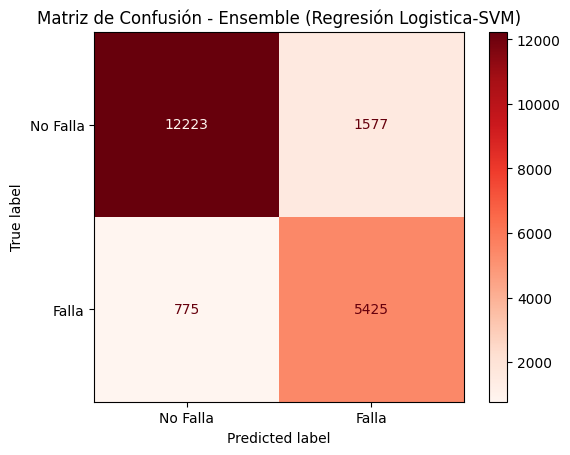

In [6]:
y_pred = ensemble.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - Ensemble (Regresión Logistica-SVM)')
plt.show()

In [7]:
paths = save_model(
    model=ensemble, 
    model_name='probl1_lr_svm',
    save_path='models/',
    metadata={
        'hyperparameters': ensemble.get_params()
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl1_lr_svm_20251226_115632.joblib


In [8]:
model = load_model('probl1_lr_svm', 'models/probl1_lr_svm_20251226_115632.joblib')

In [3]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [ ]:
# No se pudo probar la curva de aprendizaje, no me da la compu perdon :(
train_sizes, train_scores, val_scores = learning_curve( 
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 32.5%, ..., 100%
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "o-", color="tab:blue", label="Train f2_scorer")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color="tab:blue")
plt.plot(train_sizes, val_mean, "o-", color="tab:orange", label="CV f2_scorer")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color="tab:orange")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("f2_scorer")
plt.title("Curva de aprendizaje - Fault")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()